# NNet class in Pytorch

Versions:

* 3.3: *Added calls to `np.random.seed(42)` to force the shuffle in our partition function to result in the same random arrangement of samples each time, to help with your debugging.*
* 3.2: *RMSE in example output of `generate_k_fold_cross_validation_sets` are corrected. `A3grader.zip` updated.*
* 3.1: *`A3grader.zip` is now available.  The `generate_k_fold_cross_validation_sets` function had an error that is fixed in this version.*

* 3.0: *`A3grader.zip` is not available yet.*

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [1]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

Complete the following definition of class `NNet` by completing its `train` function.

In [22]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh'):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
            
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):
           
            Y = self.forward(X) 
            mse = mse_func(T, Y)
            mse.backward()
            optimizer.step() 
            optimizer.zero_grad()
            unstd_rmse= torch.sqrt(mse) * self.Tstds
            self.error_trace.append(unstd_rmse)
            #rmse=np.sqrt(np.mean((unstd_rmse - Y)**2))
            
            if verbose and ((epoch+1) % max(1,n_epochs //10)-0):
                print(f'Adam: Epoch {epoch+1:d} Error={unstd_rmse[0]:.4f}')
            

    def use(self, X):
 
       # Set input matrix to torch.tensors if not already.
         if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()

        # Standardize X
            X = (X - self.Xmeans)/ self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
            Z=self.forward(X)
            Y= (Z * self.Tstds) + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
            return Y.detach().numpy()


## Example

In [23]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Adam: Epoch 1 Error=28.1558
Adam: Epoch 2 Error=14.4755
Adam: Epoch 3 Error=10.7874
Adam: Epoch 4 Error=12.8648
Adam: Epoch 6 Error=7.5510
Adam: Epoch 7 Error=4.1964
Adam: Epoch 8 Error=4.3700
Adam: Epoch 9 Error=6.0188
Adam: Epoch 11 Error=4.8707
Adam: Epoch 12 Error=3.9343
Adam: Epoch 13 Error=3.9308
Adam: Epoch 14 Error=4.4090
Adam: Epoch 16 Error=5.2474
Adam: Epoch 17 Error=4.3238
Adam: Epoch 18 Error=3.1377
Adam: Epoch 19 Error=2.3625
Adam: Epoch 21 Error=2.4708
Adam: Epoch 22 Error=3.0120
Adam: Epoch 23 Error=3.1083
Adam: Epoch 24 Error=2.7428
Adam: Epoch 26 Error=2.0653
Adam: Epoch 27 Error=2.0040
Adam: Epoch 28 Error=2.2785
Adam: Epoch 29 Error=2.6404
Adam: Epoch 31 Error=2.2604
Adam: Epoch 32 Error=1.8114
Adam: Epoch 33 Error=1.4243
Adam: Epoch 34 Error=1.2431
Adam: Epoch 36 Error=1.6909
Adam: Epoch 37 Error=1.6575
Adam: Epoch 38 Error=1.4904
Adam: Epoch 39 Error=1.3131
Adam: Epoch 41 Error=1.1659
Adam: Epoch 42 Error=1.3681
Adam: Epoch 43 Error=1.4321
Adam: Epoch 44 Error=1.3

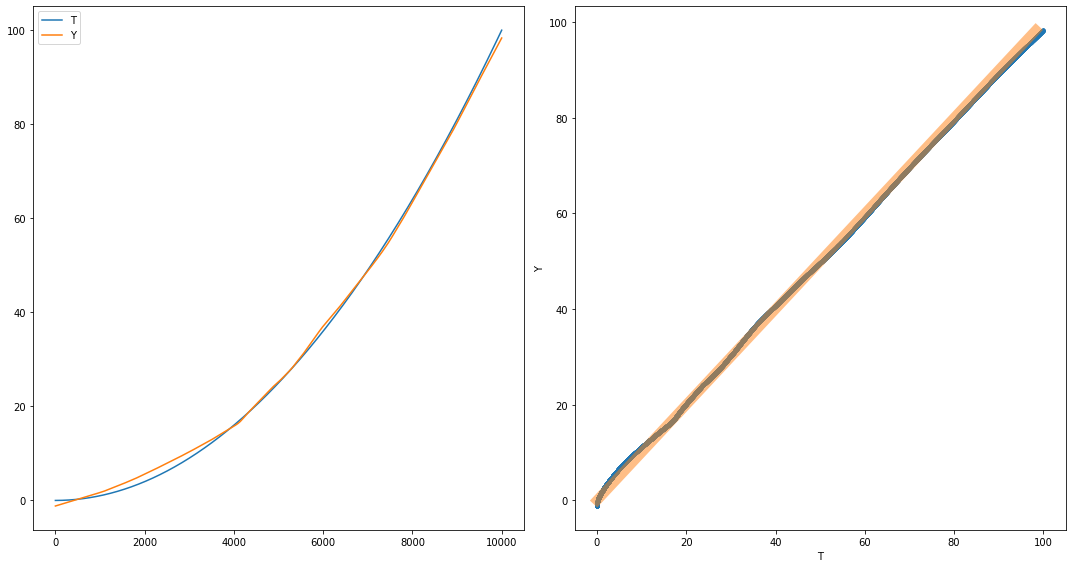

In [4]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [5]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [6]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]), array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [7]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [8]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, n_epochs, learning_rate, act_func):
    
    n_samples, n_inputs = X.shape
    n_outputs = T.shape[1]
    Outputs=[]
    
    for nh in list_of_n_hiddens:
        Train_err =0
        Val_err=0
        Test_err =0
        Count=0
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):
            nnet = NNet(Xtrain.shape[1], nh, Ttrain.shape[1],act_func)
            nnet.train(Xtrain, Ttrain, n_epochs, learning_rate)
            Train_err += rmse(Ttrain,nnet.use(Xtrain))
            Val_err += rmse(Tvalidate, nnet.use(Xvalidate))
            Test_err += rmse(Ttest, nnet.use(Xtest))
            Count = Count + 1
        Outputs.append([nh , Train_err/Count, Val_err/Count, Test_err/Count])
        df= pandas.DataFrame(Outputs, columns = ('Arch','Train RMSE','Validate RMSE','Test RMSE'))
    print(df)
    return df

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [9]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))
airfoil.isna().sum()

frequency    0
angle        0
chord        0
velocity     0
thickness    0
pressure     0
dtype: int64

In [10]:
#airfoil

Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described with at least 10 sentences.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [11]:
data=airfoil.values
X=data[:,0:5]
T=data[:,5:6]


In [12]:
X.shape, T.shape, X

((1503, 5),
 (1503, 1),
 array([[8.00000e+02, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
        [1.00000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
        [1.25000e+03, 0.00000e+00, 3.04800e-01, 7.13000e+01, 2.66337e-03],
        ...,
        [4.00000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02],
        [5.00000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02],
        [6.30000e+03, 1.56000e+01, 1.01600e-01, 3.96000e+01, 5.28487e-02]]))

In [13]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()

results = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [200, 200],[300,100],[200,200,100],[300,200,100]],
                                      500, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results

Adam: Epoch 1 Error=tensor([11.0817], grad_fn=<MulBackward0>)
Adam: Epoch 2 Error=tensor([10.8106], grad_fn=<MulBackward0>)
Adam: Epoch 3 Error=tensor([10.5484], grad_fn=<MulBackward0>)
Adam: Epoch 4 Error=tensor([10.2933], grad_fn=<MulBackward0>)
Adam: Epoch 5 Error=tensor([10.0458], grad_fn=<MulBackward0>)
Adam: Epoch 6 Error=tensor([9.8060], grad_fn=<MulBackward0>)
Adam: Epoch 7 Error=tensor([9.5742], grad_fn=<MulBackward0>)
Adam: Epoch 8 Error=tensor([9.3502], grad_fn=<MulBackward0>)
Adam: Epoch 9 Error=tensor([9.1342], grad_fn=<MulBackward0>)
Adam: Epoch 10 Error=tensor([8.9260], grad_fn=<MulBackward0>)
Adam: Epoch 11 Error=tensor([8.7254], grad_fn=<MulBackward0>)
Adam: Epoch 12 Error=tensor([8.5322], grad_fn=<MulBackward0>)
Adam: Epoch 13 Error=tensor([8.3462], grad_fn=<MulBackward0>)
Adam: Epoch 14 Error=tensor([8.1671], grad_fn=<MulBackward0>)
Adam: Epoch 15 Error=tensor([7.9946], grad_fn=<MulBackward0>)
Adam: Epoch 16 Error=tensor([7.8285], grad_fn=<MulBackward0>)
Adam: Epoch 

Arch  Train RMSE  Validate RMSE  Test RMSE
0               []    4.788780       4.837919   4.837922
1              [1]    4.437498       4.469080   4.468256
2              [5]    3.506761       3.650452   3.654613
3       [200, 200]    0.778783       1.701964   1.677426
4       [300, 100]    0.684325       1.654269   1.639746
5  [200, 200, 100]    0.473542       1.430979   1.436620
6  [300, 200, 100]    0.439757       1.419772   1.406885

Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [14]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()

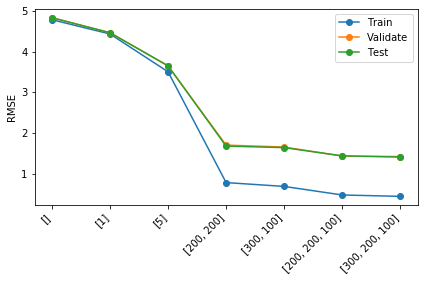

In [15]:
plot_results(results)

The following observations can be made from the Graph:

1.Both the Test and validation RMSE error decreases with increase in the number of hidden units.

2.The Test and validation RMSE error also decreases significantly when the number of hidden layer is increases.

3.Training error too follows the same trend i.e as the number of hidden layer and hidden units increases, the training error decreases.

4.The best result is obtained when the neural network has the configuration of [300,200,100] as minimum values for both the training and test error is obtained. 

# Grading and Check-In

Your notebook will be partially run and graded automatically. Test this grading process by first downloading [A3grader.zip](https://www.cs.colostate.edu/~anderson/cs445/notebooks/A3grader.zip) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. You should see a perfect execution score of 90/90 if your functions are defined correctly. The remaining 10 points will be based on other testing and the results you obtain and your discussions.

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.

For the grading script to run correctly, you must first name this notebook as `Lastname-A3.ipynb`| with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

In [16]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Chakraborty-A3.3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    
    results = r

# Extra Credit

Earn up to 2 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.

In [17]:
torch.cuda.is_available()

False